In [1]:
!pip install pytorch_pretrained_bert

In [2]:
import os
import math
import datetime
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertModel
import tensorflow as tf
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from torch.utils.data import DataLoader, Dataset

C:\Users\developer\Anaconda3\envs\intent-detection\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class IntentDetectionData(object):
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"

    def __init__(self, train, test, tokenizer: BertTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        train_preprocessed, test_preprocessed = map(
            lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare,
                                                                         [train_preprocessed, test_preprocessed])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
      x, y = [], []

      for _, row in tqdm(df.iterrows()):
          text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
          tokens = self.tokenizer.tokenize(text)
          tokens = ["[CLS]"] + tokens + ["[SEP]"]
          token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
          self.max_seq_len = max(self.max_seq_len, len(token_ids))
          x.append(token_ids)
          y.append(self.classes.index(label))

      return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [4]:
class MyBertBasedModel(BertPreTrainedModel):
    """
    MyBertBasedModel inherits from BertPreTrainedModel which is an abstract class to handle weights initialization and
        a simple interface for downloading and loading pre-trained models.
    """

    def __init__(self, config, num_labels):
        super(MyBertBasedModel, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config) # basic BERT model
        self.layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(config.hidden_size, 768),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(768, num_labels),
        )
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        sequence_output = sequence_output[:, 0, :]
        sequence_output = self.layer(sequence_output)
        return sequence_output

In [5]:
class IntentTrainDataset(Dataset):
    def __init__(self, data:IntentDetectionData):
        self.data = data
        
    def __len__(self):
        return len(self.data.train_x)

    def __getitem__(self, index):
        return torch.tensor(data.train_x[index]), torch.tensor(data.train_y[index])

In [6]:
class IntentTestDataset(Dataset):
    def __init__(self, data:IntentDetectionData):
        self.data = data
        
    def __len__(self):
        return len(self.data.test_x)

    def __getitem__(self, index):
        return torch.tensor(data.test_x[index]), torch.tensor(data.test_y[index])

In [7]:
RANDOM_SEED = 42
lr = 0.000010
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

train = train.append(valid).reset_index(drop=True)

In [9]:
# bert pretrained model weights and configuration file
bert_model_name = 'uncased_L-12_H-768_A-12'
bert_ckpt_dir = os.path.join(bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')
tokenizer = BertTokenizer(vocab_file=os.path.join(bert_ckpt_dir, 'vocab.txt'))

In [11]:
classes = train.intent.unique().tolist()
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)
train_dataset = IntentTrainDataset(data)
test_dataset = IntentTestDataset(data)
model = MyBertBasedModel.from_pretrained("uncased_L-12_H-768_A-12", num_labels=len(classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

61574it [00:29, 2089.11it/s]
1257it [00:00, 2159.61it/s]


max seq_len 16


MyBertBasedModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
  

In [12]:
# Data Loader
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets.long())

      # Backward and Optimize
      loss.backward()
      optimizer.step()
      
      train_loss.append(loss.item())

    train_losses[i] = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets.long())
      test_loss.append(loss.item())
    
    test_losses[i] = np.mean(test_loss)

    dt = datetime.now() - t0
    print(f"Epoch: {i+1} / {epochs}, Train Loss: {train_losses[i]:.4f}, Test Loss: {test_losses[i]:.4f}, Duration: {dt}")
  
  return train_losses, test_losses

In [17]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=5)

Epoch: 1 / 5, Train Loss: 0.4029, Test Loss: 0.0360, Duration: 2:53:37.259559
Epoch: 2 / 5, Train Loss: 0.0400, Test Loss: 0.0194, Duration: 2:36:57.814067
Epoch: 3 / 5, Train Loss: 0.0247, Test Loss: 0.0160, Duration: 2:21:21.966788
Epoch: 4 / 5, Train Loss: 0.0190, Test Loss: 0.0141, Duration: 2:21:13.621686
Epoch: 5 / 5, Train Loss: 0.0163, Test Loss: 0.0128, Duration: 2:21:18.396504


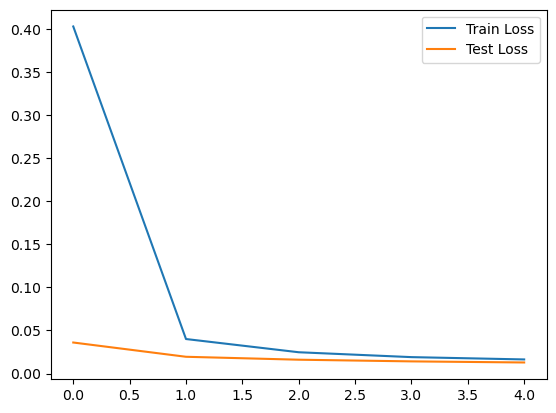

In [18]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [19]:
# Accuracy
model.eval()

n_correct = 0.
n_total = 0.
 
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward Pass
  outputs = model(inputs)

  # Get predictions 
  # torch.max return both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward Pass
  outputs = model(inputs)

  # Get predictions 
  # torch.max return both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train Accuracy:{train_acc:.4f}, Test Accuracy:{test_acc:.4f}")

Train Accuracy:0.9966, Test Accuracy:0.9960


In [104]:
# Get all the test predictions in an array and plot confusion matrix
model.eval()
y_test = test_dataset.data.test_y
p_test = np.array([])

for inputs, targets in test_loader:
    # Move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    # Forward Pass
    outputs = model(inputs)
    loss = criterion(outputs, targets.long())

    # Get prediction
    # torch.max return both max and argmax
    _, predictions = torch.max(outputs, 1)

    # Concatenate the predictions
    p_test = np.concatenate((p_test, predictions.cpu().numpy())) 

In [108]:
def compute_confusion_matrix(true, pred):
  K = true.max() + 1
  result = np.zeros((K, K))
  for t, p in zip(true, pred):
    result[int(t)][int(p)] += 1

  return result

In [109]:
cm = compute_confusion_matrix(y_test, p_test)
cm.sum()

1257.0

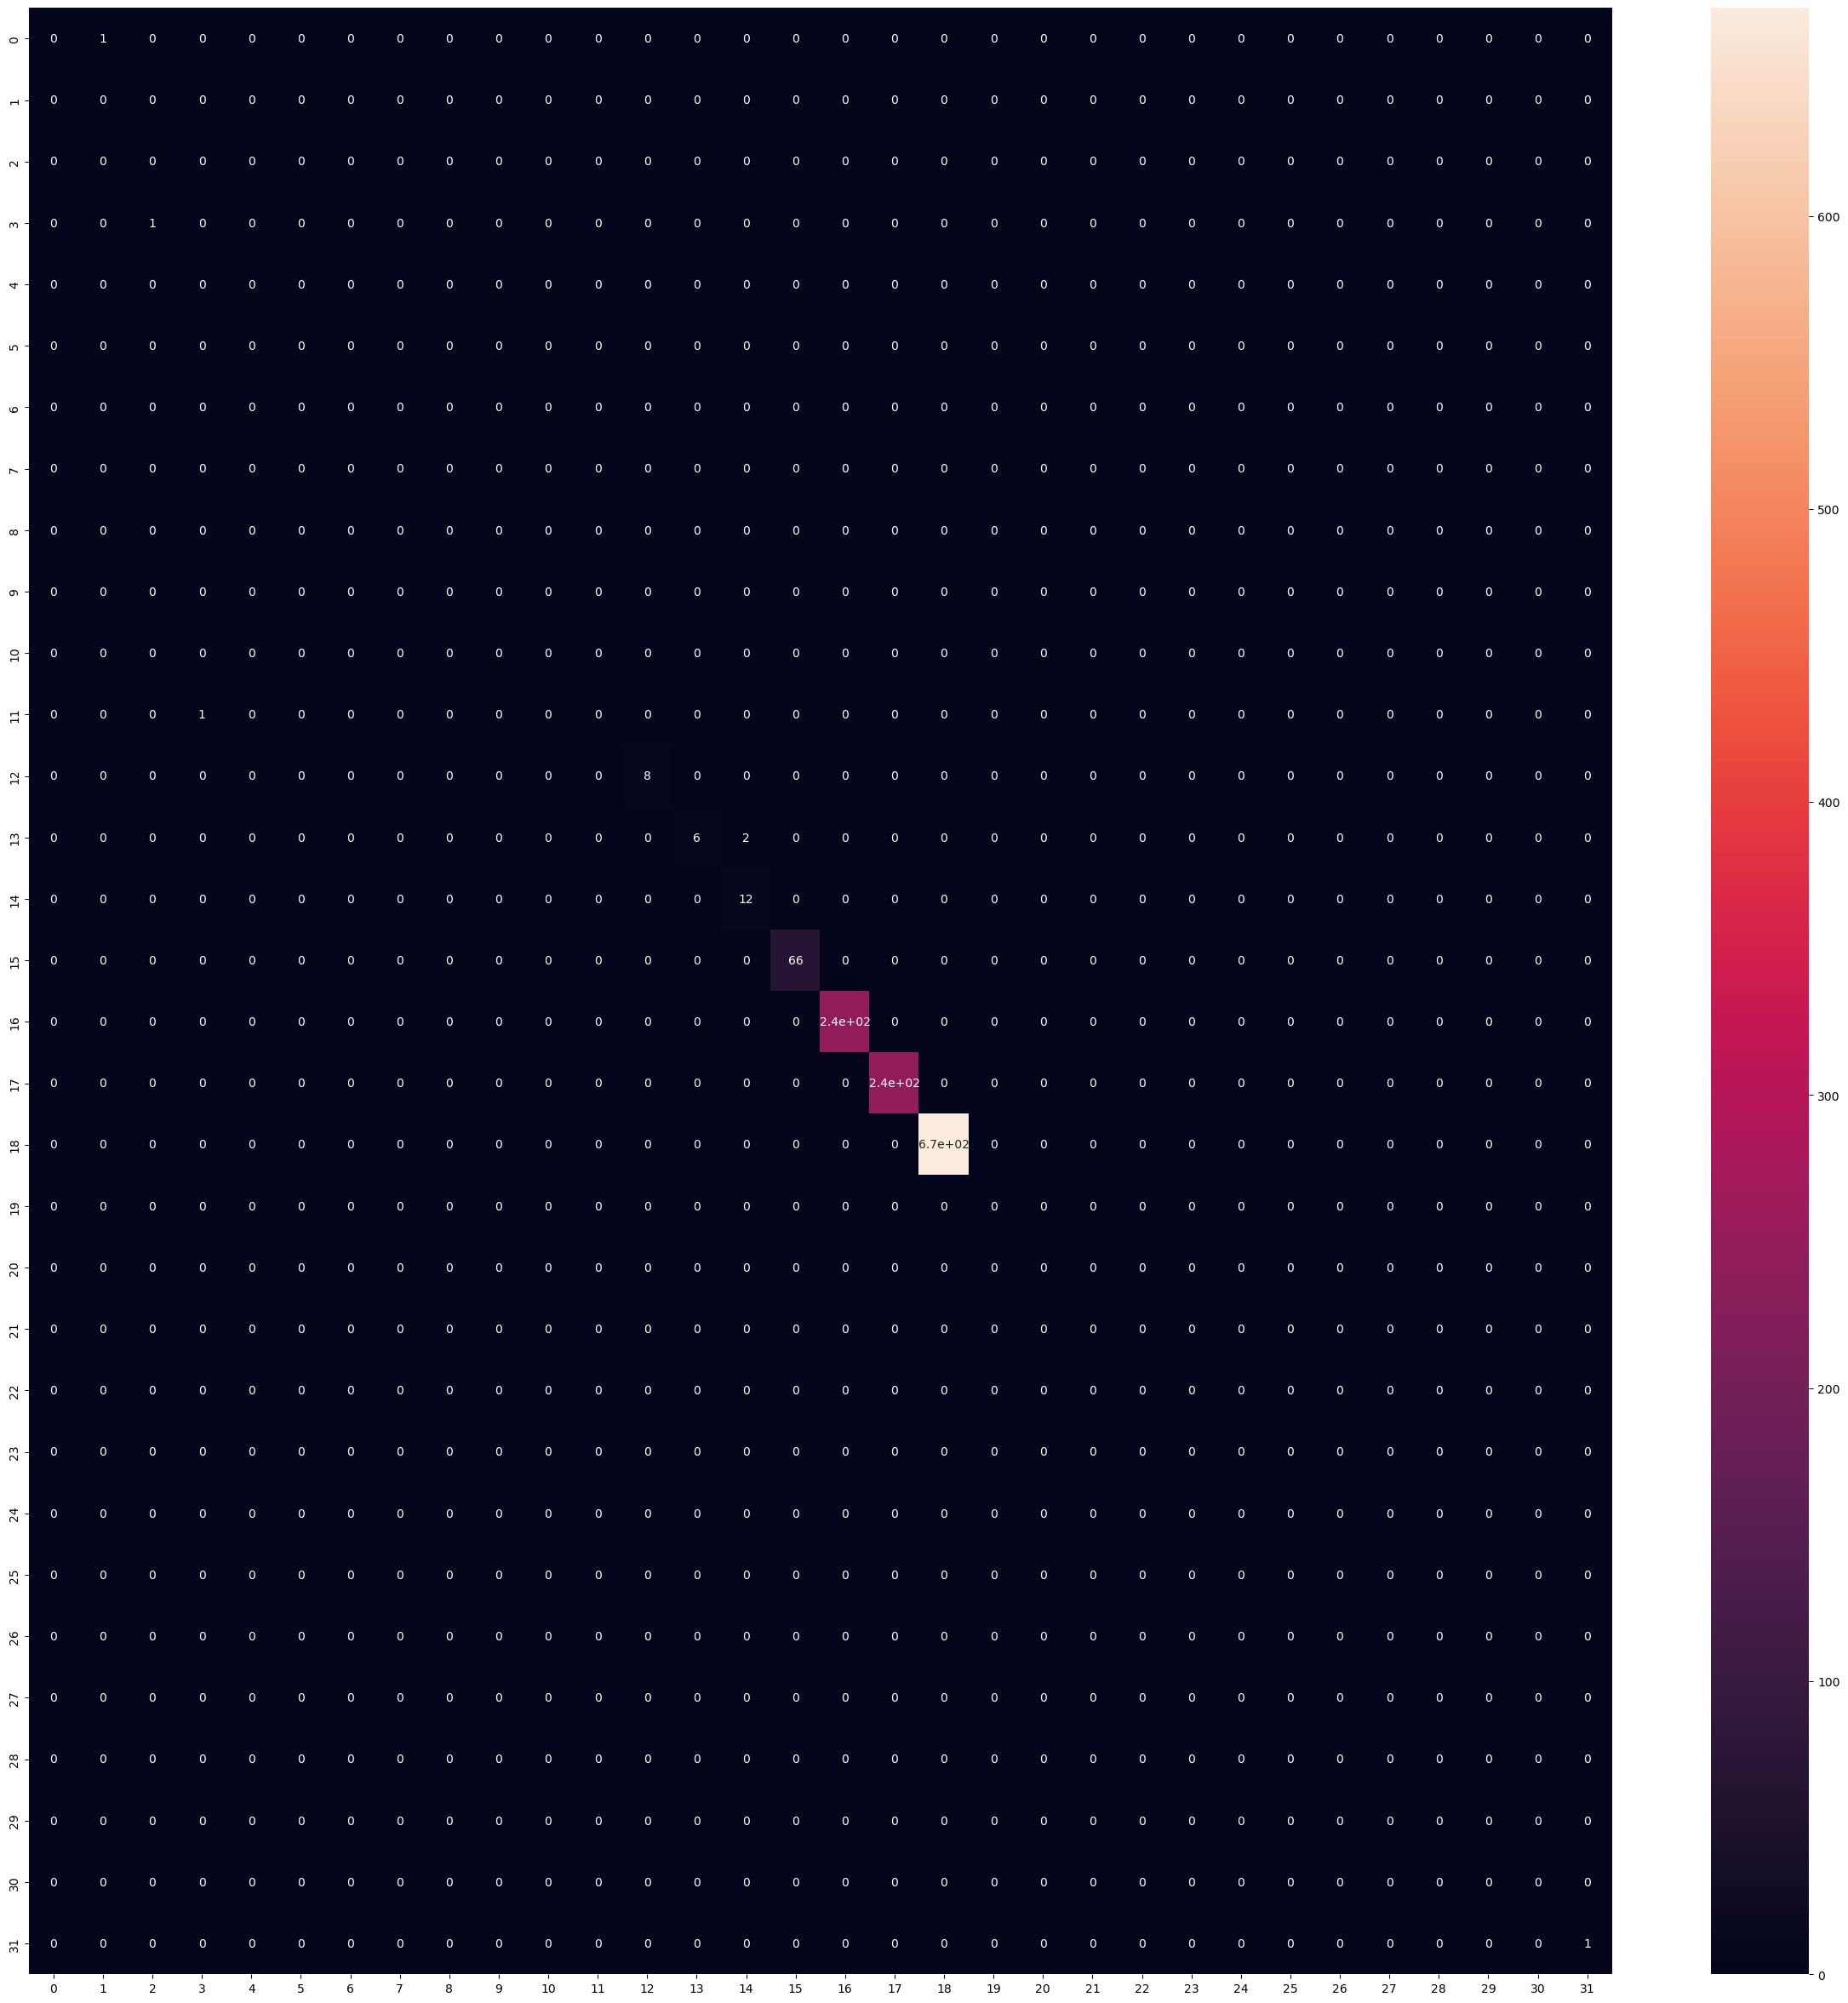

In [115]:
import seaborn as sn
plt.figure(figsize = (30,30))
sn.heatmap(cm, annot=True);